<a href="https://colab.research.google.com/github/achmadbauravindah/ImageSegmentation-CNN-XRayLungImages/blob/main/ImageSegmentation_CNN_XRayLungImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose

import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from tqdm import tqdm
import numpy as np

### Download Data

In [2]:
# Get data from Kaggle
_ = ! git clone https://github.com/achmadbauravindah/ravin_kaggle_credential.git # get credential from kaggle
_ = ! pip install kaggle # install kaggle on device
_ = ! mkdir ~/.kaggle # make hidden folder .kaggle to configure credential
_ = ! cp ravin_kaggle_credential/kaggle.json ~/.kaggle/ # copy credential from github to .kaggle folder
_ = ! chmod 600 ~/.kaggle/kaggle.json # change access
_ = ! kaggle datasets download x-ray-scan-lung-images # which dataset to download
_ = ! unzip x-ray-scan-lung-images # unzip if data zipped

### Global Variable

In [3]:
# SET UP GLOBAL VARIABLE
DEFAULT_IMG_WIDTH = 512
DEFAULT_IMG_HEIGHT = 512
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
DATA_PATH = 'dataset_x_ray_scan_lung_images'

## Preprocessing data

In [4]:
sample_image_path = os.path.join(DATA_PATH, 'train', 'image', 'cxrimage_0.png')
image_default_pixel = img_to_array(load_img(sample_image_path))
image_default_pixel.shape

(512, 512, 3)

In [5]:
def getArrImages(path, total = 100):
  # saved array
  images_arr = []
  masks_arr = []

  # Set Path image and mask
  images_path = os.path.join(path, 'image')
  masks_path = os.path.join(path, 'mask')

  # total_images in directory
  # images_total = len(os.listdir(images_path))
  # masks_total = len(os.listdir(masks_path))
  # total = images_total # images and masks have same total
  
  # Get array from images and masks
  for idx in tqdm(range(total)):
    # IMAGES
    image_path = images_path + '/cxrimage_' + str(idx) +'.png'
    image = load_img(image_path, color_mode='rgb', target_size=(IMG_HEIGHT, IMG_WIDTH))
    image_arr = img_to_array(image).astype('float32') / 255.0
    images_arr.append(image_arr)
    # MASKS
    mask_path = masks_path + '/cxrmask_' + str(idx) +'.jpeg'
    mask = load_img(mask_path, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
    mask_arr = img_to_array(mask).astype('float32') / 255.0
    masks_arr.append(mask_arr)

  return np.array(images_arr), np.array(masks_arr)


In [6]:
# Create Path
path_train = os.path.join(os.getcwd(), DATA_PATH, 'train')
path_val = os.path.join(os.getcwd(), DATA_PATH, 'val')
path_test = os.path.join(os.getcwd(), DATA_PATH, 'test')

In [7]:
# Call getArrImages to Get Array All Images and Data
train_images, train_masks = getArrImages(path_train, 1000)
val_images, val_masks = getArrImages(path_val, 200)
test_images, test_masks = getArrImages(path_test, 200)

100%|██████████| 200/200 [00:02<00:00, 74.89it/s]


In [8]:
# Shape All Data
print("Shape of Training Data - Images: {}, Masks: {}".format(train_images.shape, train_masks.shape))
print("Shape of Validation Data - Images: {}, Masks: {}".format(val_images.shape, val_masks.shape))
print("Shape of Testing Data - Images: {}, Masks: {}".format(test_images.shape, test_masks.shape))

Shape of Training Data - Images: (1000, 256, 256, 3), Masks: (1000, 256, 256, 1)
Shape of Validation Data - Images: (200, 256, 256, 3), Masks: (200, 256, 256, 1)
Shape of Testing Data - Images: (200, 256, 256, 3), Masks: (200, 256, 256, 1)


### Model CNN Building for Segmentation


In [9]:
model = Sequential([
    Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)), 
    Conv2D(5, (3,3), activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(7, (3,3), activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(11, (3,3), activation='relu', padding='same'),
    MaxPool2D((2,2)),

    Conv2DTranspose(11, (3,3), strides=(2,2), padding='same'),
    Conv2DTranspose(7, (3,3), strides=(2,2), padding='same'),
    Conv2DTranspose(5, (3,3), strides=(2,2), padding='same'),

    Conv2D(5, (3,3), activation='relu', padding='same'),
    Conv2D(1, (1,1), activation='sigmoid', padding='same'),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 5)       140       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 5)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 7)       322       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 7)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 11)        704       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 11)       0

In [11]:
# Model Training
history = model.fit(train_images, 
                    train_masks, 
                    validation_data=(val_images, val_masks), 
                    batch_size=32,
                    epochs=100)

Epoch 1/100
32/32 [==============================] - 18s 114ms/step - loss: 0.6507 - accuracy: 0.7298 - val_loss: 0.5709 - val_accuracy: 0.7236
Epoch 2/100
32/32 [==============================] - 3s 89ms/step - loss: 0.5520 - accuracy: 0.7345 - val_loss: 0.5451 - val_accuracy: 0.7236
Epoch 3/100
32/32 [==============================] - 3s 89ms/step - loss: 0.5261 - accuracy: 0.7345 - val_loss: 0.5058 - val_accuracy: 0.7236
Epoch 4/100
32/32 [==============================] - 3s 89ms/step - loss: 0.4840 - accuracy: 0.7345 - val_loss: 0.4351 - val_accuracy: 0.7236
Epoch 5/100
32/32 [==============================] - 3s 88ms/step - loss: 0.4243 - accuracy: 0.7654 - val_loss: 0.3630 - val_accuracy: 0.8310
Epoch 6/100
32/32 [==============================] - 3s 88ms/step - loss: 0.4009 - accuracy: 0.7920 - val_loss: 0.3469 - val_accuracy: 0.8331
Epoch 7/100
32/32 [==============================] - 3s 90ms/step - loss: 0.3902 - accuracy: 0.7976 - val_loss: 0.3361 - val_accuracy: 0.8362
Epoc

In [13]:
pred = model.predict(test_images)

pred = (pred > 0.5).astype(np.uint8)

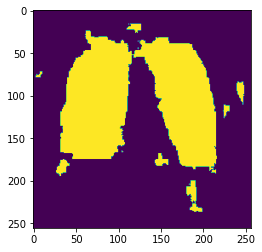

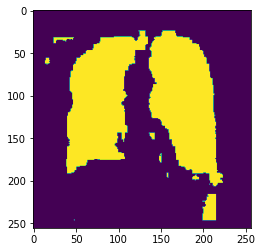

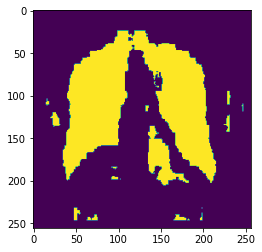

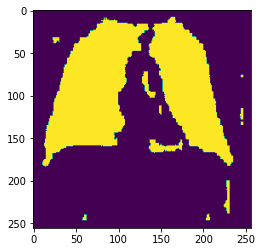

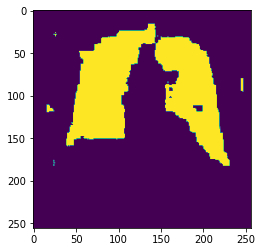

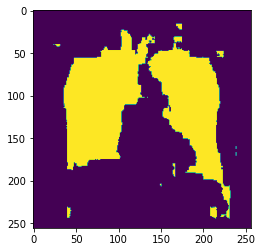

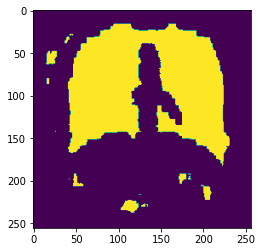

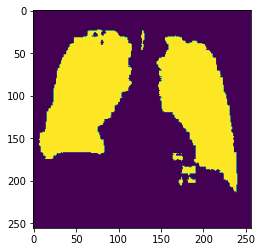

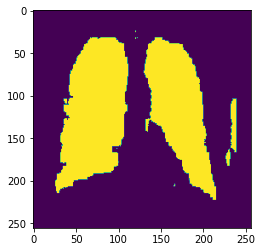

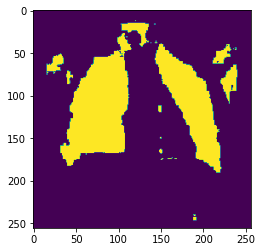

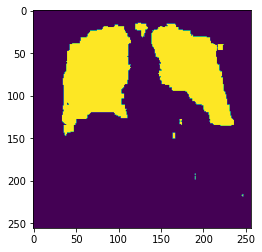

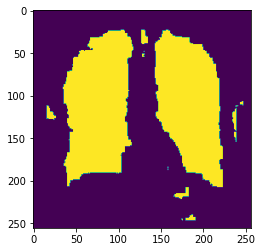

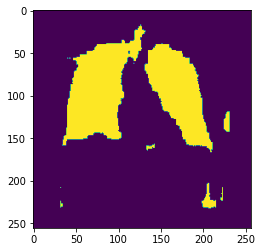

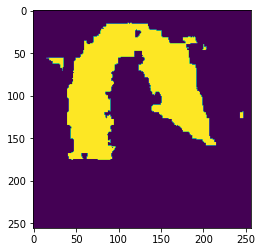

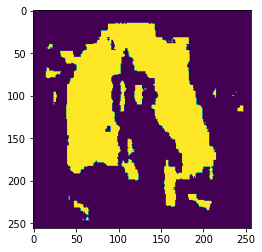

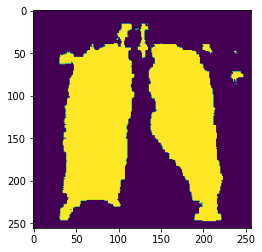

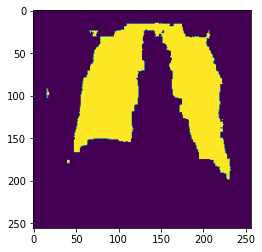

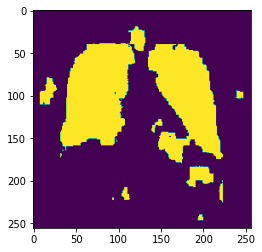

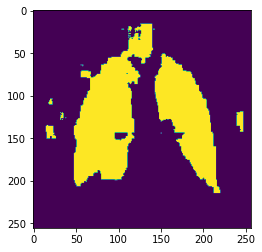

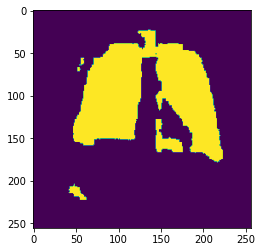

In [14]:
for i in range(20):
  plt.imshow(np.squeeze(pred[i]))
  plt.show()